In [392]:
import pandas as pd
import numpy as np
import datetime as datetime 
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 1.  Data Load

In [597]:
pd.low_memory=False
RejectStats = pd.read_excel("Data_Dictionary.xlsx", sheet_name=1)
RejectStats.head(20)
loan_all = pd.read_csv("loan.csv")
loan_all.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [622]:
loan_all.shape

(39717, 45)

# 2.  Data Cleaning 
### 1. Removing columns with all nulls and sinlge value in all rows
* Checking the shape and checking nulls again

In [623]:
### Getting a list of columns having all nulls more than 35% threshhold
allnulls = loan_all.isnull().sum()

### Getting a list of columns having unique values 
uniques = loan_all.nunique()

## Concatinating both list 
removeIndexes = np.concatenate((uniques[uniques==1].index.values, 
                               allnulls[allnulls>(loan_all.shape[0]*0.35)].index.values))

## Removing from Loan Data
loan_all = loan_all.drop(removeIndexes, axis=1)
loan_all.shape

(39717, 45)

### 2. Removing columns with max nulls after checking the use of columns and checking shape

In [624]:
# loan_all = loan_all.drop(loan_all.isnull().sum().sort_values(ascending=False)[:4].index, axis=1)
loan_all.shape

(39717, 45)

In [625]:
## checking columns having more nulls
loan_all.isnull().sum().sort_values(ascending=False)[:10]

desc                    12940
emp_title                2459
emp_length               1075
pub_rec_bankruptcies      697
last_pymnt_d               71
revol_util                 50
title                      11
last_credit_pull_d          2
out_prncp_inv               0
open_acc                    0
dtype: int64

### 3. Checking "Object" column types and converting the types of Required columns

In [628]:
loan_all.select_dtypes(include=['object']).head()

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,url,desc,purpose,title,zip_code,addr_state,earliest_cr_line,revol_util,last_pymnt_d,last_credit_pull_d
0,36 months,10.65%,B,B2,NaN,10+ years,RENT,Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,Jan-85,83.70%,Jan-15,May-16
1,60 months,15.27%,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-11,Charged Off,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,Apr-99,9.40%,Apr-13,Sep-13
2,36 months,15.96%,C,C5,NaN,10+ years,RENT,Not Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,Nov-01,98.50%,Jun-14,May-16
3,36 months,13.49%,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,Feb-96,21%,Jan-15,Apr-16
4,60 months,12.69%,B,B5,University Medical Group,1 year,RENT,Source Verified,Dec-11,Current,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,Jan-96,53.90%,May-16,May-16


### 4. Converting the following fields from Object type to Int/float

* term  (Renaming "term" to "term_months" Removing "months" from data)
* int_rate (removing % from data)
* revol_util (Renaming "revol_util_percent" removing % from data )


### 5. Renaming and Adding years in date column

* issue_d             - >  "issue_date" and Adding Years
* earliest_cr_line    - >  Adding Years
* last_pymnt_d        - >  "last_pymnt_date" and Adding Years
* last_credit_pull_d  - >  "last_credit_pull_date" and Adding Years

### 6. Replacing XX to blank in Zipcode


### 7. Dropping other non-required columns


### 9. Replacing "emp_title" = "Self-Employed"


### 8. Extracting all Current loans to another list loan_curr and Removing from loan_all


In [629]:
# Uncomment all lines and Run Once only
def removePercent(x):
    return float(x[:-1]) if str(x)[-1]=="%" else x

loan_all["term_months"] = loan_all["term"].apply(lambda x: int(x[0:3]))
loan_all["int_rate"] = loan_all["int_rate"].apply(removePercent)
loan_all["revol_util_percent"] = loan_all["revol_util"].apply(removePercent)

def addCentury(x):
    if str(x)[-2:]=="an":
        return "No Date"
    else:
        return str(x)[:-2]+str(20)+str(x)[-2:] if int(str(x)[-2:])<22 else str(x)[:-2]+str(19)+str(x)[-2:]

loan_all["issue_date"] = loan_all["issue_d"].apply(addCentury)
loan_all["earliest_cr_line"] = loan_all["earliest_cr_line"].apply(addCentury)
loan_all["last_pymnt_date"] = loan_all["last_pymnt_d"].apply(addCentury)
loan_all["last_credit_pull_date"] = loan_all["last_credit_pull_d"].apply(addCentury)

# Replacing XX to blank in Zipcode
loan_all["zip_code"] = loan_all["zip_code"].apply(lambda x: int(x.rstrip("xx")))
# Dropping the non required/duplicated columns
loan_all = loan_all.drop(columns=["term", "revol_util", "issue_d", "last_pymnt_d", "last_credit_pull_d"], axis=1)

# Dropping other non-required columns
loan_all = loan_all.drop(columns=["url","id","desc"], axis=1)

# Replacing "emp_title" = "Self-Employed" (if "emp_title" is null and "purpose" is "small_business")
def updateTitle(x):
    if (pd.isnull(x["emp_title"]) & (x["purpose"]=="small_business")):
        return "Self-Employed"
    else:
        return x["emp_title"]

loan_all["emp_title"]=loan_all.loc[:,["emp_title", "purpose"]].apply(updateTitle, axis=1)


## Extracting all Current loans to another list loan_curr and Removing from loan_all
loan_curr = loan_all[loan_all.loan_status=="Current"]
loan_all = loan_all[-(loan_all.loan_status=="Current")]

In [630]:
loan_all.emp_title.value_counts()

Self-Employed                               356
US Army                                     131
Bank of America                             107
IBM                                          65
AT&T                                         57
                                           ... 
Net Equity Financial                          1
Kernersville Fire Department                  1
The Keith Corp. (empl by county, now Kei      1
Bertie Middle School                          1
Evergreen Center                              1
Name: emp_title, Length: 28027, dtype: int64

In [551]:
loan_all.select_dtypes(include=['object'])[(loan_all.emp_title.isnull())]["purpose"].value_counts()
# loan["url"].value_counts()

debt_consolidation    804
credit_card           300
other                 272
home_improvement      208
major_purchase        146
car                    84
medical                47
moving                 40
vacation               37
wedding                35
house                  30
educational            26
renewable_energy       14
Name: purpose, dtype: int64

In [631]:
loan_all.select_dtypes(include=['object'])[(loan_all.emp_title.isnull())]["title"].value_counts()
# loan["url"].value_counts()

Debt Consolidation           88
Debt Consolidation Loan      70
debt consolidation           31
Personal Loan                26
Other Loan                   20
                             ..
IVF                           1
Debt Consolidation loan       1
Marriage                      1
Bathroom Home Improvement     1
JAL Loan                      1
Name: title, Length: 1394, dtype: int64

In [634]:
loan_all.select_dtypes(include=['object']).head()

,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,loan_status,purpose,title,addr_state,earliest_cr_line,issue_date,last_pymnt_date,last_credit_pull_date
0,B,B2,NaN,10+ years,RENT,Verified,Fully Paid,credit_card,Computer,AZ,Jan-1985,Dec-2011,Jan-2015,May-2016
1,C,C4,Ryder,< 1 year,RENT,Source Verified,Charged Off,car,bike,GA,Apr-1999,Dec-2011,Apr-2013,Sep-2013
2,C,C5,Self-Employed,10+ years,RENT,Not Verified,Fully Paid,small_business,real estate business,IL,Nov-2001,Dec-2011,Jun-2014,May-2016
3,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Fully Paid,other,personel,CA,Feb-1996,Dec-2011,Jan-2015,Apr-2016
5,A,A4,Veolia Transportaton,3 years,RENT,Source Verified,Fully Paid,wedding,My wedding loan I promise to pay back,AZ,Nov-2004,Dec-2011,Jan-2015,Jan-2016


In [635]:
loan_all.select_dtypes(include=['int']).head()

,member_id,loan_amnt,funded_amnt,zip_code,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,term_months,issue_month,issue_year
0,1296599,5000,5000,860,0,1,3,0,13648,9,36,12,2011
1,1314167,2500,2500,309,0,5,3,0,1687,4,60,12,2011
2,1313524,2400,2400,606,0,2,2,0,2956,10,36,12,2011
3,1277178,10000,10000,917,0,1,10,0,5598,37,36,12,2011
5,1311441,5000,5000,852,0,3,9,0,7963,12,36,12,2011


In [636]:
loan_all.select_dtypes(include=['float']).head()

,funded_amnt_inv,int_rate,installment,annual_inc,dti,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies,revol_util_percent
0,4975.0,10.65,162.87,24000.0,27.65,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,171.62,0.0,83.7
1,2500.0,15.27,59.83,30000.0,1.00,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0,9.4
2,2400.0,15.96,84.33,12252.0,8.72,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,649.91,0.0,98.5
3,10000.0,13.49,339.31,49200.0,20.00,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,357.48,0.0,21.0
5,5000.0,7.90,156.46,36000.0,11.20,0.0,0.0,5632.210000,5632.21,5000.00,632.21,0.00,0.00,0.00,161.03,0.0,28.3


# 3.  Derived Columns
### 1. Extracting  "issue_month" and  "issue_year" from  "issue_date"

In [820]:
loan_all["issue_month"]=pd.DatetimeIndex(loan_all.issue_date).month
loan_all["issue_year"]=pd.DatetimeIndex(loan_all.issue_date).year

### 2. Make segments of int_rate.

In [647]:
loan_all.int_rate.describe()
# Since min int_rate is 5.42 and max >24.4 making 5 segments from 5 to 25.

count    38577.000000
mean        11.932219
std          3.691327
min          5.420000
25%          8.940000
50%         11.710000
75%         14.380000
max         24.400000
Name: int_rate, dtype: float64

In [665]:
def makeRateGroups(x):
    if x<10:
        return "0-10"
    elif x<13:
        return "10-13"
    elif x<16:
        return "13-16"
    elif x<19:
        return "16-19"
    elif x>=19:
        return ">19"

# Make groups of int_rate.
loan_all['int_rate_category'] = loan_all.int_rate.apply(makeRateGroups)
loan_all['int_rate_category'].value_counts()

0-10     12067
10-13    11931
13-16     9076
16-19     4103
>19       1400
Name: int_rate_category, dtype: int64

### 3. Make segments of dti.

In [666]:
# Using the same segments used in "int_rate" for "dti"
loan_all['dti_category'] = loan_all.dti.apply(makeRateGroups)
loan_all['dti_category'].value_counts()

0-10     12905
>19       8899
13-16     5860
10-13     5666
16-19     5247
Name: dti_category, dtype: int64

### 4. Make segments of Amount.

In [656]:
loan_all.loan_amnt.describe()
# Since min int_rate is 500 and max 35000 making 5 segments from 500 to 35000.

count    38577.000000
mean     11047.025430
std       7348.441646
min        500.000000
25%       5300.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

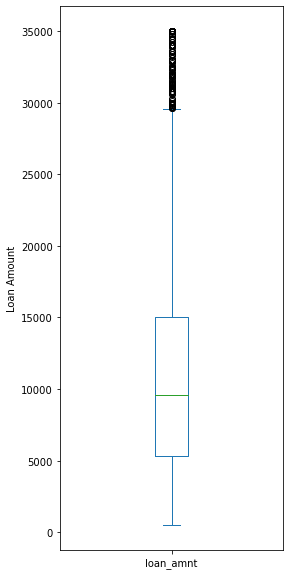

In [837]:
plt.figure(figsize=[4,10])
plt.ylabel("Loan Amount")
loan_all.loan_amnt.plot.box()
plt.show()

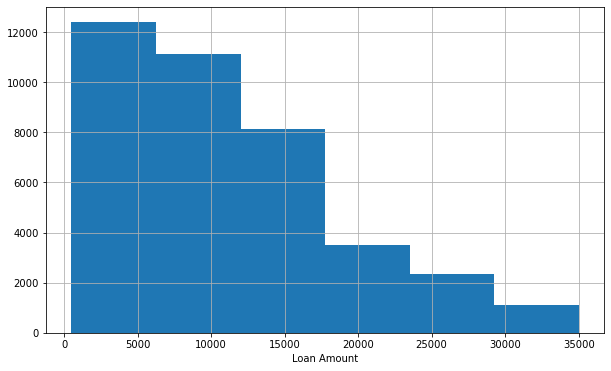

In [836]:
plt.figure(figsize=[10,6])
plt.xlabel("Loan Amount")
loan_all.loan_amnt.hist(bins=6)
plt.show()

In [805]:
def makeAmtGroups(x):
    if x<5000:
        return "0-5000"
    elif x<10000:
        return "5000-10000"
    elif x<15000:
        return "10000-15000"
    elif x<20000:
        return "15000-20000"
    elif x<25000:
        return "20000-25000"
    elif x>=25000:
        return ">25000"

# Make groups of int_rate.
loan_all['loan_amnt_category'] = loan_all.loan_amnt.apply(makeAmtGroups)
loan_all['loan_amnt_category'].value_counts()

5000-10000     12021
10000-15000     8654
0-5000          7444
15000-20000     4651
20000-25000     3045
>25000          2762
Name: loan_amnt_category, dtype: int64

In [854]:
loan_all.annual_inc.describe()

count    3.857700e+04
mean     6.877797e+04
std      6.421868e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.886800e+04
75%      8.200000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

In [865]:
def makeIncomeGroups(x):
    if x<30000:
        return "0-30000"
    elif x<50000:
        return "30000-50000"
    elif x<80000:
        return "50000-80000"
    elif x<100000:
        return "80000-100000"
    elif x<150000:
        return "100000-150000"
    elif x>=150000:
        return ">150000"

# Make groups of int_rate.
loan_all['annual_inc_category'] = loan_all.annual_inc.apply(makeIncomeGroups)
loan_all['annual_inc_category'].value_counts()

50000-80000      13586
30000-50000      10617
80000-100000      4652
100000-150000     4270
0-30000           3743
>150000           1709
Name: annual_inc_category, dtype: int64

# 4. Univariate Analysis

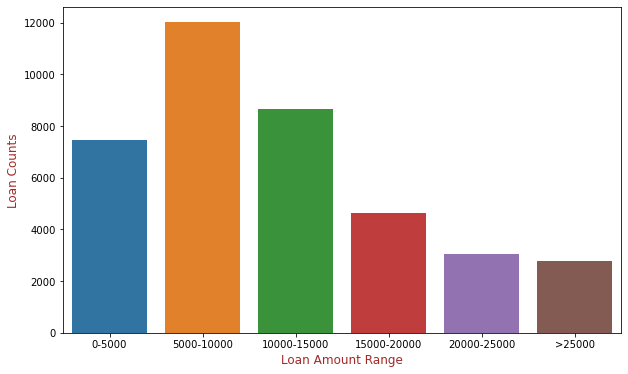

In [834]:
#Univariate analysis for Loan Amount Ranges
plt.figure(figsize=[10,6])
sns.countplot(x = 'loan_amnt_category', data=loan_all, 
              order = ["0-5000", "5000-10000", "10000-15000", "15000-20000", "20000-25000", ">25000"])
plt.xlabel("Loan Amount Range", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.ylabel("Loan Counts", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'} )
plt.show()

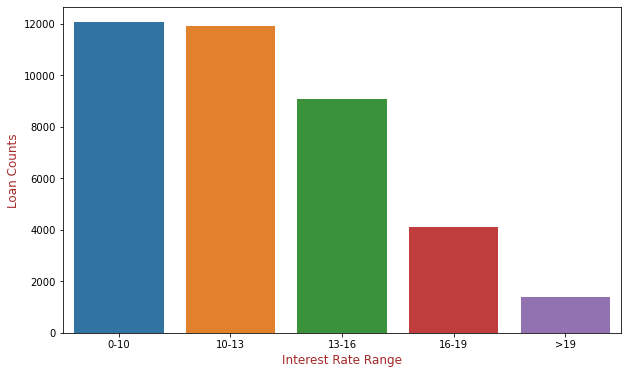

In [844]:
#Univariate analysis for Interest Rate Ranges
plt.figure(figsize=[10,6])
sns.countplot(x = 'int_rate_category', data=loan_all, 
              order = ["0-10","10-13","13-16","16-19",">19"])
plt.xlabel("Interest Rate Range", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.ylabel("Loan Counts", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'} )
plt.show()

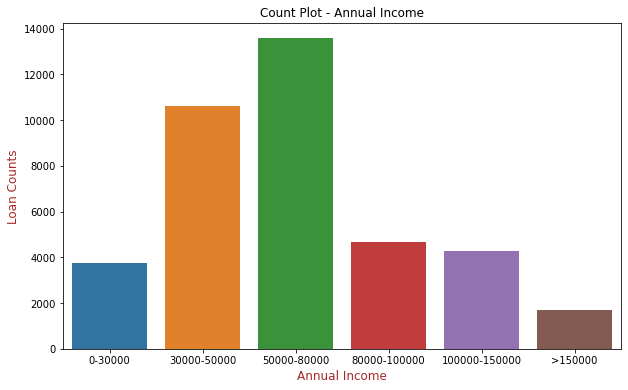

In [872]:
# #Univariate analysis for Annual Income Ranges
#Create a count Plot of the Annual Income Ranges

plt.figure(figsize=[10,6])
sns.countplot(x = 'annual_inc_category', data=loan_all, 
              order = ["0-30000","30000-50000","50000-80000","80000-100000","100000-150000",">150000"])
plt.title('Count Plot - Annual Income')
plt.xlabel("Annual Income", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.ylabel("Loan Counts", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'} )
plt.show()

# From the count plot below we can deduce that Annual income of customers that are taking loan is around 30k-80k range


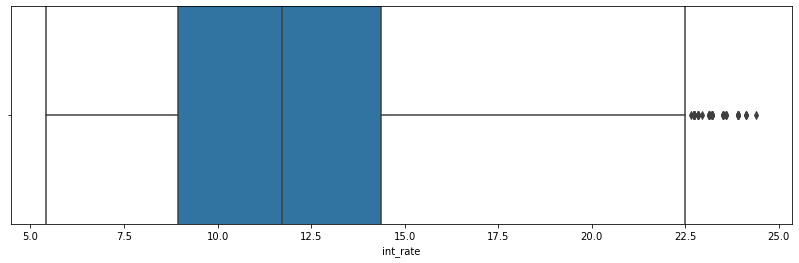

In [842]:
plt.figure(figsize=[14,4])
sns.boxplot(x = 'int_rate', data = loan_all, width=8)
plt.show()

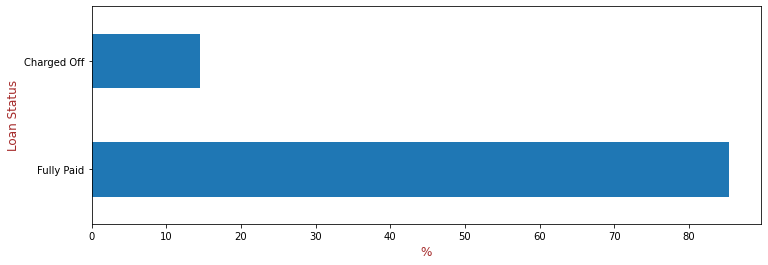

In [843]:
#Univariate analysis for Loan Status and percent of lons
loan_status_per = pd.Series(loan_all.loan_status.value_counts()).apply(
    lambda x: (x/loan_all.loan_status.value_counts().sum())*100)

plt.ylabel("Loan Status", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.xlabel("%", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'} )
loan_status_per.plot(kind="barh", figsize=[12,4])
plt.xticks(rotation=0)
plt.show()

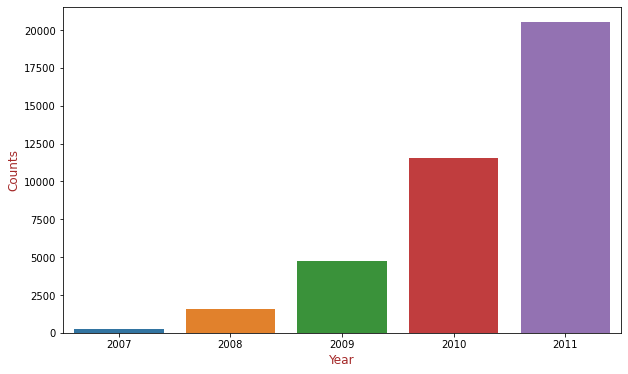

In [831]:
#Univariate analysis for Loan disbursed yearly
plt.figure(figsize=[10,6])
sns.countplot(x = 'issue_year', data=loan_all)
plt.xlabel("Year", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.ylabel("Counts", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'} )
plt.show()

# 5. Bivariate Analysis

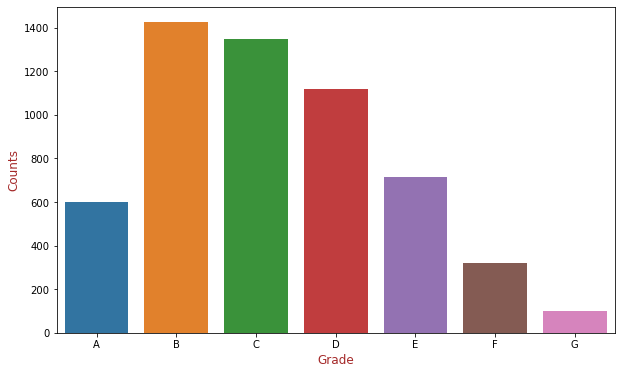

In [830]:
#Bivariate analysis for Loan disbursed yearly
plt.figure(figsize=[10,6])
sns.countplot(x = 'grade', data = loan_all[loan_all.loan_status == 'Charged Off'], 
              order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.xlabel("Grade", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.ylabel("Counts", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'} )
plt.show()

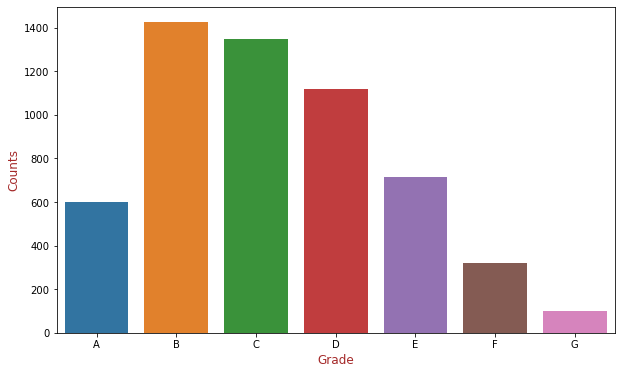

In [839]:
#Bivariate analysis for Charged Off loan grade wise
plt.figure(figsize=[10,6])
sns.countplot(x = 'grade', data = loan_all[loan_all.loan_status == 'Charged Off'], 
              order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.xlabel("Grade", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.ylabel("Counts", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'} )
plt.show()

# 6. Pairplot Analysis

# 7. Segmented Univariate Analysis